In [3]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
from pathlib import Path
import matplotlib as mpl
import random
from numba import njit

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [114]:

def generative_process(T=20):
    x = [np.random.normal()]
    for t in range(1,T):
        x.append(x[0])
    return np.array(x)


def model_process(t=20):
    # generate each time step from standard normal distribution for t time steps
    x = np.random.normal(size=t)
    return x

#def generative_trajectories(n=100, t=20):
    
#    traj = np.array([generative_process(t) for _ in range(n)])
    
#    return traj


def generative_trajectories(n=100, t=20):
    dates = pd.to_datetime(['2023-02-12','2023-02-19','2023-02-26','2023-03-04','2023-03-11', '2023-03-18', 
                            '2023-03-25' ,'2023-04-01', '2023-04-08' ,'2023-04-15' ,'2023-04-22', '2023-04-29', 
                            '2023-05-06', '2023-05-13', '2023-05-20', '2023-05-27',
                            '2023-06-03', '2023-06-10', '2023-06-17', '2023-06-24'])
    traj = pd.DataFrame()
    for j in range(n):
        v = []
        init = np.random.normal()
        for i in range(t):
            v.append(init)
        v1 = pd.DataFrame({'value':v, 'target_end_date':dates})
        v1['Model'] = 'generative'
        v1['trajectory_id'] = j
        
        traj = pd.concat([traj, v1])
    return traj



#def model_trajectories(n=100, t=20):
    
#    traj = np.array([model_process(t) for _ in range(n)])
    
#    return traj


def model_trajectories(n=100, t=20):
    dates = pd.to_datetime(['2023-02-12','2023-02-19','2023-02-26','2023-03-04','2023-03-11', '2023-03-18', 
                            '2023-03-25' ,'2023-04-01', '2023-04-08' ,'2023-04-15' ,'2023-04-22', '2023-04-29', 
                            '2023-05-06', '2023-05-13', '2023-05-20', '2023-05-27',
                            '2023-06-03', '2023-06-10', '2023-06-17', '2023-06-24'])
    traj = pd.DataFrame()
    for j in range(n):
        v = []
        for i in range(t):
            v.append(np.random.normal())
        
        v1 = pd.DataFrame({'value':v, 'target_end_date':dates})
        v1['Model'] = 'generative'
        v1['trajectory_id'] = j
        
        traj = pd.concat([traj, v1])
    return traj




def WIS(X,y, quantiles=[0.01,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.60,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.975,0.99]):
    #X is the matrix of trajectories
    #calculate quantiles
    Q = np.quantile(X,quantiles,axis=0)
    WIS = np.zeros(X.shape[1])
    for i in range(len(quantiles) // 2):
        interval_range = 100*(quantiles[-i-1]-quantiles[i])
        alpha = 1-(quantiles[-i-1]-quantiles[i])
        IS = interval_score(y,Q[i],Q[-i-1],interval_range)
        WIS += IS['interval_score']*alpha/2
    WIS += 0.5*np.abs(Q[len(quantiles) // 2 +1] - y)
        
    return np.sum(WIS) / (len(quantiles) // 2 + 0.5)

In [222]:
@njit
def energyscore(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum((X[i]-y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum((X[i]-X[j])**2))/(2*N**2)
    return ES


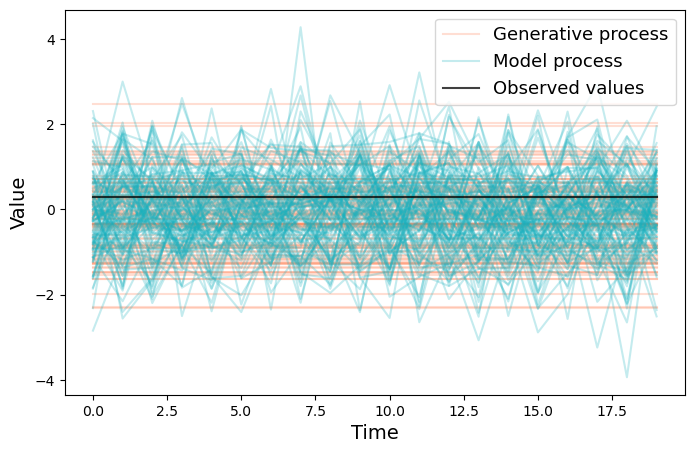

In [225]:
fig, axes = plt.subplots(figsize=(8, 5))
g1 = generative_trajectories(n=100)
g2 = model_trajectories(n=100)
g2['trajectory_id'] = g2['trajectory_id'] + 100
g = pd.concat([g1, g2])

for i in g.trajectory_id.unique():
    gf = g[g.trajectory_id == i]
    
    if i <100:
        color = 'coral'
        
    else:
        color =  '#17B1BF'
        
    #plt.plot(range(10), gf['value'], color = color, alpha = .25)
    
    if i ==1:
        plt.plot(range(20), gf['value'], color = color, alpha = .25, label ='Generative process')
    elif i==110:
        plt.plot(range(20), gf['value'], color = color, alpha = .25, label='Model process')
    else:
        plt.plot(range(20), gf['value'], color = color, alpha = .25)

plt.plot(range(20), generative_process(), color = 'k', alpha = .75, label='Observed values')
    

    
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)

plt.legend(fontsize=13)

#plt.savefig('../figs/trajectories_test_flat.pdf')
plt.show()

In [22]:
traj

array([[ 1.63771872,  1.63771872,  1.63771872, ...,  1.63771872,
         1.63771872,  1.63771872],
       [-0.32448433, -0.32448433, -0.32448433, ..., -0.32448433,
        -0.32448433, -0.32448433],
       [-0.08987887, -0.08987887, -0.08987887, ..., -0.08987887,
        -0.08987887, -0.08987887],
       ...,
       [-1.48476459, -1.48476459, -1.48476459, ..., -1.48476459,
        -1.48476459, -1.48476459],
       [ 0.5344403 ,  0.5344403 ,  0.5344403 , ...,  0.5344403 ,
         0.5344403 ,  0.5344403 ],
       [ 0.413471  ,  0.413471  ,  0.413471  , ...,  0.413471  ,
         0.413471  ,  0.413471  ]])

In [54]:
N = 1000
M = 20

numit = 2500

ES1 = []
ES2 = []
WIS1 = []
WIS2 = []

for _ in range(numit):
    y = generative_process(M)
    X1 = np.array([generative_process(M) for _ in range(N)])
    X2 = np.array([model_process(M) for _ in range(N)])
    ES1.append(energyscore(X1,y))
    ES2.append(energyscore(X2,y))
    WIS1.append(WIS(X1,y))
    WIS2.append(WIS(X2,y))
ES1_mean = np.mean(ES1)
ES2_mean = np.mean(ES2)
WIS1_mean = np.mean(WIS1)
WIS2_mean = np.mean(WIS2)

In [58]:
print('model ES = ' + str(round(ES2_mean,2)))
print('generative ES = ' + str(round(ES1_mean,2)))

print('model WIS = ' + str(round(WIS2_mean,2)))
print('generative WIS = ' + str(round(WIS1_mean,2)))

model ES = 2.92
generative ES = 2.56
model WIS = 10.22
generative WIS = 10.23


In [63]:
ES1_mean = np.quantile(ES1,.75)
ES2_mean = np.quantile(ES2,.75)
WIS1_mean = np.quantile(WIS1, .75)
WIS2_mean = np.quantile(WIS2 ,.75)

print('model ES = ' + str(round(ES2_mean,2)))
print('generative ES = ' + str(round(ES1_mean,2)))

print('model WIS = ' + str(round(WIS2_mean,2)))
print('generative WIS = ' + str(round(WIS1_mean,2)))

model ES = 3.64
generative ES = 3.16
model WIS = 12.58
generative WIS = 12.53


In [43]:
N = 1000
M = 20

X1 = np.array([generative_process(10) for _ in range(N)])
X2 = np.array([model_process(10) for _ in range(N)])

dftot = pd.DataFrame()
for model in ['Generative', 'Model']:
    if model == 'Generative':
        dat = X1
    else:
        dat = X2
    for i in range(len(X1)):
        df = pd.DataFrame(dat[i], columns = ['value'])
        df['time'] = [1,2,3,4,5,6,7,8,9,10]
        
        df['Model'] = model + ' Process'
        dftot=pd.concat([dftot, df])

In [42]:
dftot

,value,time,Model
0,1.614136,1,generative
1,1.614136,2,generative
2,1.614136,3,generative
3,1.614136,4,generative
4,1.614136,5,generative
...,...,...,...
5,-0.461994,6,model
6,1.037372,7,model
7,-1.572005,8,model
8,1.400825,9,model


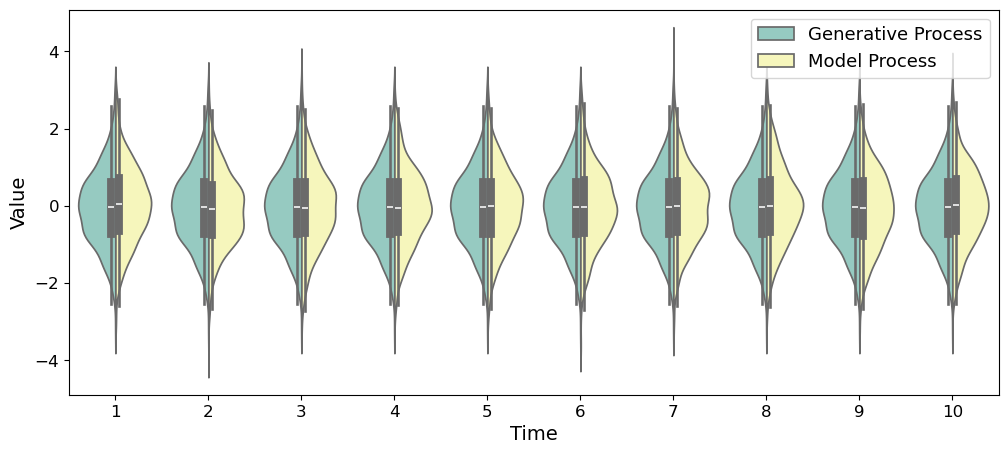

In [50]:
# plot distributions at each time step
fig, axes = plt.subplots(figsize=(12, 5))

sns.violinplot(x="time", y="value", hue="Model",
            data=dftot, split=True, palette='Set3')

plt.xlabel('Time', fontsize=14)
plt.ylabel('Value',fontsize=14)
axes.set_xticklabels([1,2,3,4,5,6,7,8,9,10], fontsize=12)
#axes.set_yticklabels(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='', fontsize=13)

plt.savefig('../figs/marginaldist_flat.pdf')
plt.show()

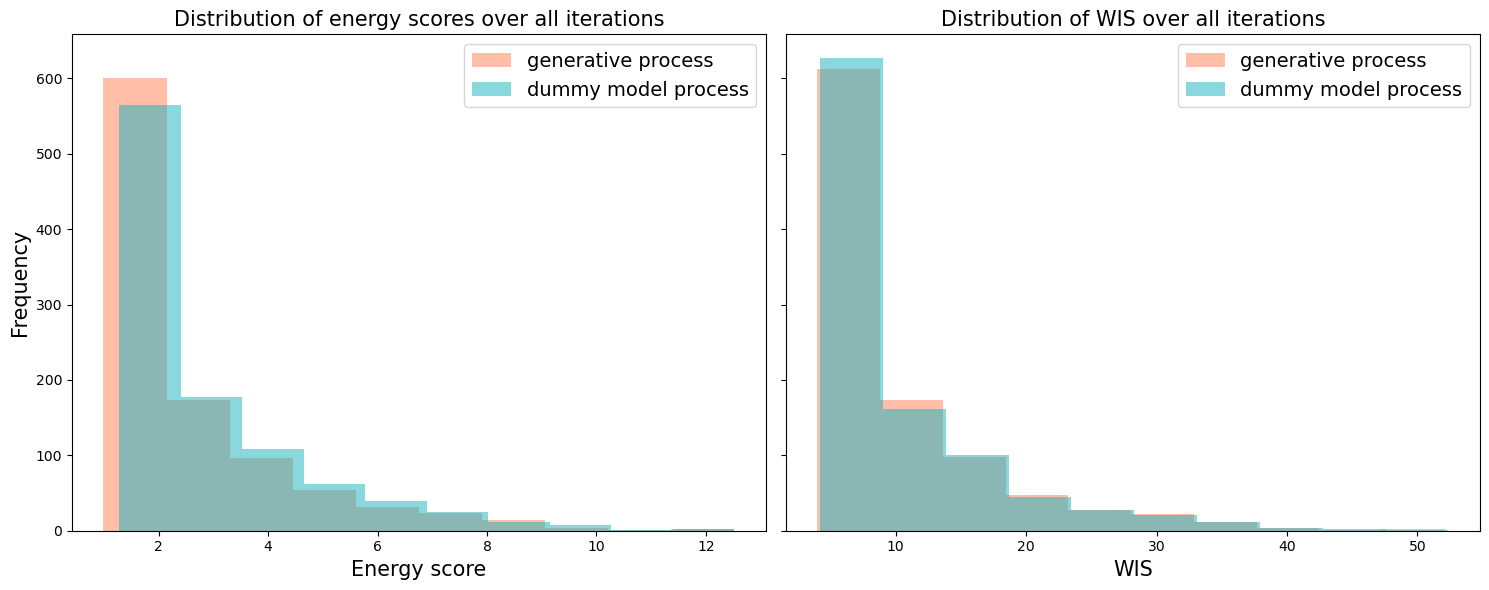

In [86]:
fig = plt.subplots(1,2,figsize=(15, 6), sharey=True)

plt.subplot(1,2,1)

plt.hist(ES1,alpha=0.5,color = 'coral', label='generative process')
plt.hist(ES2,alpha=0.5, color = '#17B1BF', label = 'dummy model process')

plt.xlabel('Energy score', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title('Distribution of energy scores over all iterations', fontsize=15)
plt.legend(fontsize=14)

plt.subplot(1,2,2)

plt.hist(WIS1,alpha=0.5,color = 'coral', label='generative process')
plt.hist(WIS2,alpha=0.5, color = '#17B1BF', label = 'dummy model process')

plt.xlabel('WIS', fontsize=15)
#plt.ylabel('Frequency', fontsize=13)
plt.title('Distribution of WIS over all iterations', fontsize=15)
plt.legend(fontsize=14)
plt.tight_layout()

plt.savefig('distofscores.png')
plt.show()

In [116]:
# increasing/decreasing processes

In [8]:
def generative_process_inc(t=10):
    # generate a flat line drawn from a standard normal distribution with length t
    v = []
    init = np.random.normal()
    for i in range(t):
        v.append(init*(i+1))
        
    v = np.array(v)
    
    return v


def model_process_inc(t=10):
    # generate each time step from standard normal distribution for t time steps
    v = []
    for i in range(t):
        v.append(np.random.normal(0, i+1))
        
    v = np.array(v)
        
    return v


def generative_trajectories_inc(n=100, t=10):
    dates = pd.to_datetime(['2023-04-22', '2023-04-29', '2023-05-06', '2023-05-13', '2023-05-20', '2023-05-27',
                            '2023-06-03', '2023-06-10', '2023-06-17', '2023-06-24'])
    traj = pd.DataFrame()
    for j in range(n):
        v = []
        init = np.random.normal()
        for i in range(t):
            v.append(init*(i+1))
        v1 = pd.DataFrame({'value':v, 'target_end_date':dates})
        v1['Model'] = 'generative'
        v1['trajectory_id'] = j
        
        traj = pd.concat([traj, v1])
    return traj


def model_trajectories_inc(n=100, t=10):
    dates = pd.to_datetime(['2023-04-22', '2023-04-29', '2023-05-06', '2023-05-13', '2023-05-20', '2023-05-27',
                            '2023-06-03', '2023-06-10', '2023-06-17', '2023-06-24'])
    traj = pd.DataFrame()
    for j in range(n):
        v = []
        for i in range(t):
            v.append(np.random.normal(0,i+1))
        
        v1 = pd.DataFrame({'value':v, 'target_end_date':dates})
        v1['Model'] = 'model'
        v1['trajectory_id'] = j
        
        traj = pd.concat([traj, v1])
    return traj

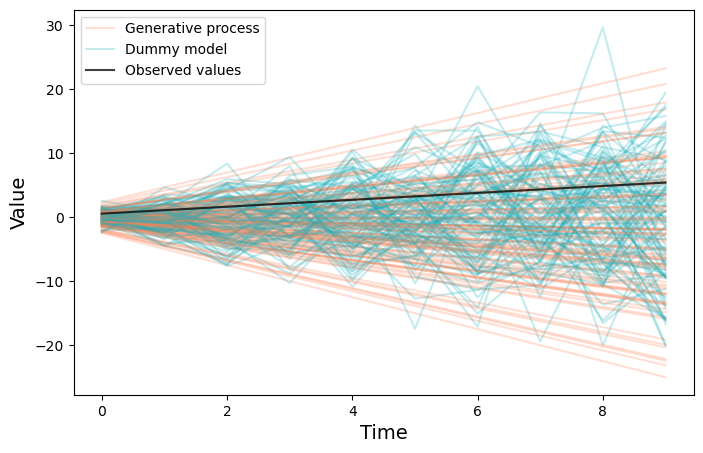

In [103]:
fig, axes = plt.subplots(figsize=(8, 5))



nb_sample = 100
for i in range(nb_sample):
    plt.plot(generative_process_inc(), color='coral', label='Generative process' if i == 0 else None, alpha=.25)
    plt.plot(model_process_inc(), color='#17B1BF', label='Dummy model' if i == 0 else None, alpha=.25)

plt.plot(range(10), generative_process_inc(), color = 'k', alpha = .75, label='Observed values')

plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)

plt.legend()

plt.savefig('trajectories_test_inc.png')
plt.show()

In [108]:
N=1000
X1 = np.array([generative_process_inc(10) for _ in range(N)])
X2 = np.array([model_process_inc(10) for _ in range(N)])

dftot = pd.DataFrame()
for model in ['generative', 'model']:
    if model == 'generative':
        dat = X1
    else:
        dat = X2
    for i in range(len(X1)):
        df = pd.DataFrame(dat[i], columns = ['value'])
        df['time'] = [1,2,3,4,5,6,7,8,9,10]
        
        df['Model'] = model
        dftot=pd.concat([dftot, df])


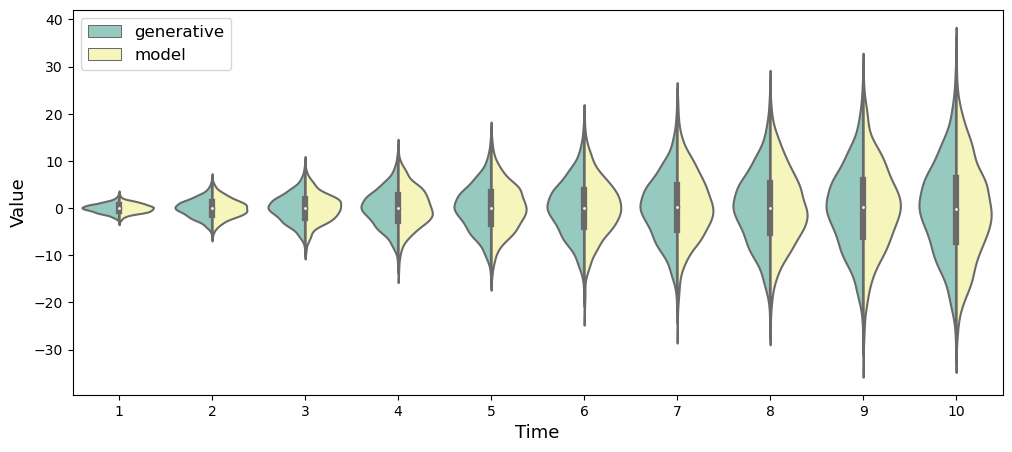

In [115]:
# plot distributions at each time step
fig, axes = plt.subplots(figsize=(12, 5))

sns.violinplot(x="time", y="value", hue="Model",
            data=dftot, split=True, palette='Set3')

plt.xlabel('Time', fontsize=13)
plt.ylabel('Value',fontsize=13)
axes.set_xticklabels([1,2,3,4,5,6,7,8,9,10])

plt.legend(loc='upper left', fontsize=12)
plt.savefig('marginaldist_inc.png')
plt.show()

In [116]:
N = 1000
M = 20

numit = 1000

ES1 = []
ES2 = []
WIS1 = []
WIS2 = []

for _ in range(numit):
    y = generative_process_inc(M)
    X1 = np.array([generative_process_inc(M) for _ in range(N)])
    X2 = np.array([model_process_inc(M) for _ in range(N)])
    ES1.append(energyscore(X1,y))
    ES2.append(energyscore(X2,y))
    WIS1.append(WIS(X1,y))
    WIS2.append(WIS(X2,y))
ES1_mean = np.mean(ES1)
ES2_mean = np.mean(ES2)
WIS1_mean = np.mean(WIS1)
WIS2_mean = np.mean(WIS2)

In [118]:
print('model ES = ' + str(ES2_mean))
print('generative ES = ' + str(ES1_mean))

print('model WIS = ' + str(WIS2_mean))
print('generative WIS = ' + str(WIS1_mean))

model ES = 34.96042880628862
generative ES = 30.936848421444413
model WIS = 108.18889391375455
generative WIS = 108.36279978442518


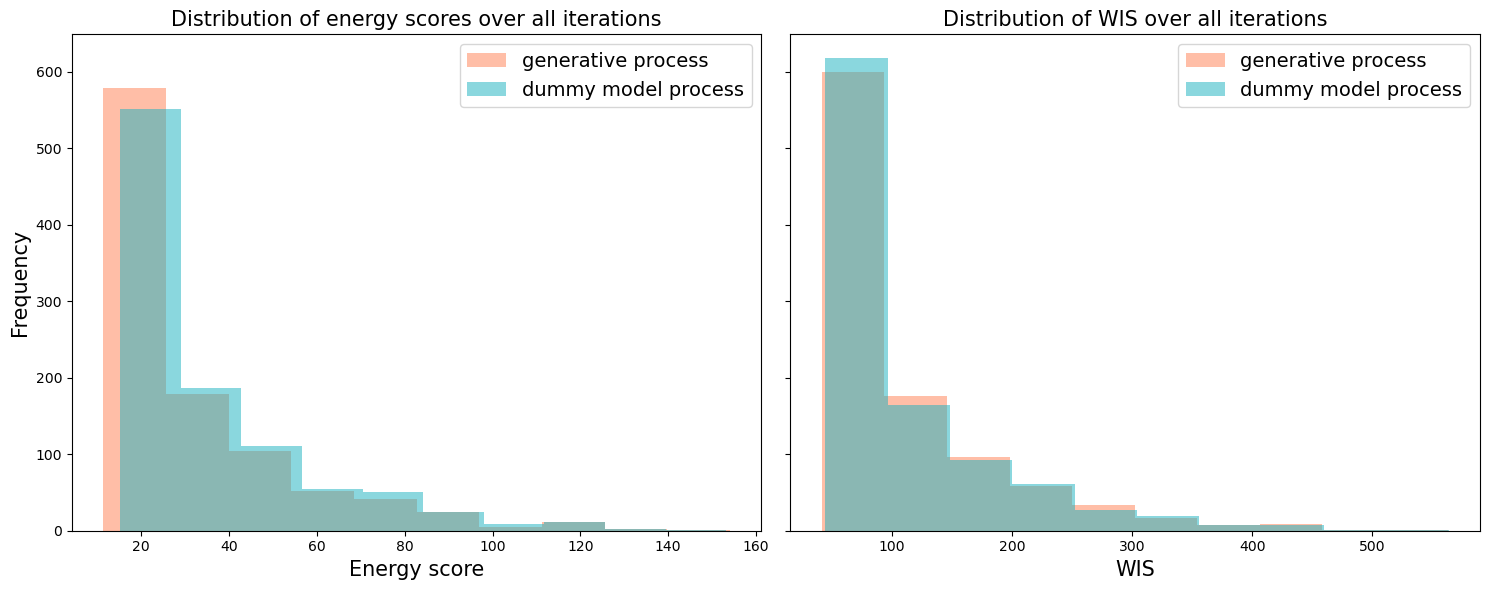

In [126]:
fig = plt.subplots(1,2,figsize=(15, 6), sharey=True)

plt.subplot(1,2,1)

plt.hist(ES1,bins=10,alpha=0.5,color = 'coral', label='generative process')
plt.hist(ES2,bins=10,alpha=0.5, color = '#17B1BF', label = 'dummy model process')

plt.xlabel('Energy score', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title('Distribution of energy scores over all iterations', fontsize=15)
plt.legend(fontsize=14)

plt.subplot(1,2,2)

plt.hist(WIS1,bins=10,alpha=0.5,color = 'coral', label='generative process')
plt.hist(WIS2,bins=10,alpha=0.5, color = '#17B1BF', label = 'dummy model process')

plt.xlabel('WIS', fontsize=15)
#plt.ylabel('Frequency', fontsize=13)
plt.title('Distribution of WIS over all iterations', fontsize=15)
plt.legend(fontsize=14)
plt.tight_layout()

#plt.savefig('distofscores_inc.png')
plt.show()

# old code:

In [286]:
dates = pd.to_datetime(['2023-04-22', '2023-04-29', '2023-05-06', '2023-05-13', '2023-05-20', '2023-05-27',
                            '2023-06-03', '2023-06-10', '2023-06-17', '2023-06-24'])
N = 200
M = 10

es_out = pd.DataFrame()
wis_out = pd.DataFrame()
for i in range(100):
    for model in ['model', 'generative']:

        gfilt = g[g.Model ==model]
        # first term
        obs = generative_process()
        observations = pd.DataFrame({'value':obs, 'target_end_date':dates})
        pfilt = gfilt.merge(observations, how='left', on=['target_end_date'])
        pfilt['diff_sq']=(pfilt.value_x - pfilt.value_y)**2

        ES1 = 1/N*sum(np.sqrt(np.array(pfilt.groupby(['trajectory_id']).sum()['diff_sq'])))


        # second term

        cross = gfilt.merge(gfilt, how='cross')
        crossfilt = cross.loc[(cross['target_end_date_x'] == cross['target_end_date_y']) ]

        crossfilt['diff_sq'] = (crossfilt.value_x - crossfilt.value_y)**2
        ES2 = 1/(2*N**2) * sum(np.sqrt(np.array(crossfilt.groupby(['trajectory_id_x',
                                                                   'trajectory_id_y']).sum()['diff_sq'])))

        ES = ES1 - ES2

        es = pd.DataFrame({'Model':model, 'ES':ES, 'iteration':i}, index=[0])
        es_out = pd.concat([es_out, es])
        
        
        # calculate WIS

        # transform trajectories into quantiles
        quants = [.01, .025, .05, .1, .15, .2, .25, .3, .35, .4, .45, .5, .55, .6, .65, .7, .75, .8,
                  .85, .9, .95, .975, .99]

        quantdf = pd.DataFrame()
        for q in quants:
            qval = list(gfilt.groupby('target_end_date')['value'].quantile(q))

            qdf = pd.DataFrame({'value':qval, 'target_end_date':dates})
            qdf['quantile'] = q
            qdf['Model'] = model

            quantdf = pd.concat([quantdf, qdf])

        gg = Predictions(quantdf, t_col='target_end_date')
        d = score_utils.all_timestamped_scores_from_df(Observations(observations, t_col = 'target_end_date'), gg)

        wisvals = list(d['wis'])

        wis_df = pd.DataFrame({'wis':wisvals, 'target_end_date':dates})
        wis_df['Model'] = model
        wis_df['iteration'] = i
        
        wis_out = pd.concat([wis_out, wis_df])


es_out = es_out.reset_index()
es_out = es_out.drop(columns=['index'])   

In [287]:
wissumdf = pd.DataFrame()
for it in wis_out.iteration.unique():
    for model in ['model', 'generative']:

        s = wis_out[(wis_out.iteration == it)& (wis_out.Model==model)]['wis'].sum()
        
        ws = pd.DataFrame({'wis_sum':s, 'Model':model, 'iteration':it}, index = [0])
        
        wissumdf = pd.concat([wissumdf, ws])
        
wissumdf = wissumdf.reset_index()
wissumdf = wissumdf.drop(columns=['index'])   

In [288]:
print('model WIS = ' + str(wissumdf[wissumdf.Model =='model'].wis_sum.mean()))
print('generative WIS = ' + str(wissumdf[wissumdf.Model =='generative'].wis_sum.mean()))

model WIS = 12.885544662520992
generative WIS = 12.115400489851329


In [289]:
print('model ES = ' + str(es_out[es_out.Model =='model'].ES.mean()))
print('generative ES = ' + str(es_out[es_out.Model =='generative'].ES.mean()))

model ES = 5.970283458117646
generative ES = 4.733499340180336


# Try new thing

In [26]:
N = 100
M = 20

numit = 100

scores = pd.DataFrame()

for ob in np.linspace(-3,3,25):

    ES1 = []
    ES2 = []
    WIS1 = []
    WIS2 = []

    for _ in range(numit):
        y = np.ones(M)*ob
        X1 = np.array([model_process(M) for _ in range(N)])
        ES1.append(energyscore(X1,y))
        WIS1.append(WIS(X1,y))

    ES1_mean = np.mean(ES1)
    WIS1_mean = np.mean(WIS1)

    newrow = pd.DataFrame({'observation':ob, 'ES':ES1_mean, 'WIS':WIS1_mean}, index=[0])
    
    scores = pd.concat([scores, newrow])
    
scores = scores.reset_index().drop(columns=['index'])

In [27]:
scores

,observation,ES,WIS
0,-3.00,11.004729,45.680071
1,-2.75,9.957910,40.727704
2,-2.50,8.915155,35.806152
3,-2.25,7.881628,30.924490
4,-2.00,6.848292,26.148881
5,-1.75,5.887717,21.864096
6,-1.50,4.913569,17.785706
7,-1.25,4.006022,14.121006
8,-1.00,3.173787,10.883372
9,-0.75,2.434103,8.164549


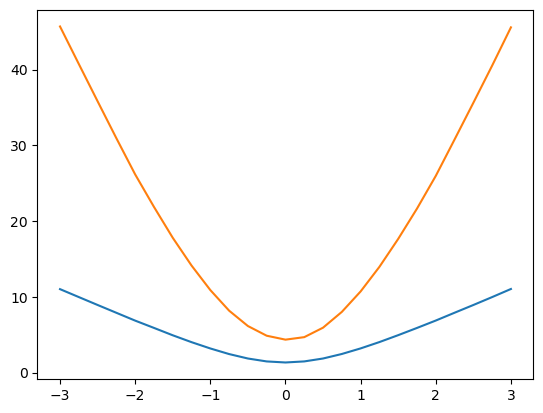

In [28]:
plt.plot(scores.observation, scores.ES)
plt.plot(scores.observation, scores.WIS)

In [45]:
def model_process_narrow(t=20):
    # generate each time step from standard normal distribution for t time steps
    x = np.random.normal(0,.25,size=t)
    return x

#def generative_trajectories(n=100, t=20):
    
#    traj = np.array([generative_process(t) for _ in range(n)])
    
#    return traj


def model_trajectories_narrow(n=100, t=20):
    dates = pd.to_datetime(['2023-02-12','2023-02-19','2023-02-26','2023-03-04','2023-03-11', '2023-03-18', 
                            '2023-03-25' ,'2023-04-01', '2023-04-08' ,'2023-04-15' ,'2023-04-22', '2023-04-29', 
                            '2023-05-06', '2023-05-13', '2023-05-20', '2023-05-27',
                            '2023-06-03', '2023-06-10', '2023-06-17', '2023-06-24'])
    traj = pd.DataFrame()
    for j in range(n):
        v = []
        for i in range(t):
            v.append(np.random.normal(0,.25))
        
        v1 = pd.DataFrame({'value':v, 'target_end_date':dates})
        v1['Model'] = 'generative'
        v1['trajectory_id'] = j
        
        traj = pd.concat([traj, v1])
    return traj



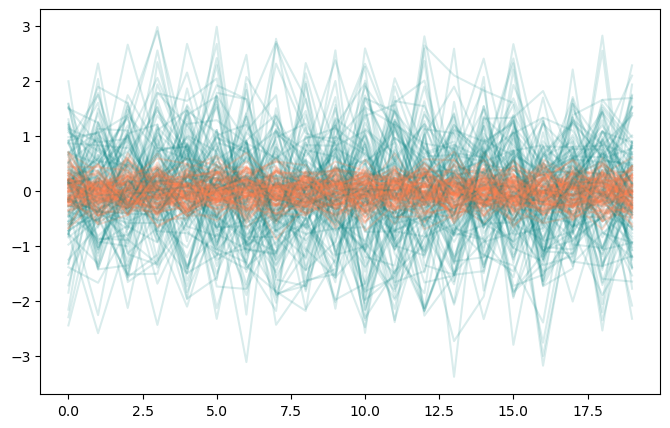

In [46]:
fig, axes = plt.subplots(figsize=(8, 5))
g = model_trajectories_narrow(n=100)
g2 = model_trajectories(n=100)
for i in g.trajectory_id.unique():
    gf = g[g.trajectory_id == i]
    gf2 = g2[g2.trajectory_id==i]
    
    color = 'coral'
           
    #plt.plot(range(10), gf['value'], color = color, alpha = .25)
    
    plt.plot(range(20), gf['value'], color = color, alpha = .25, label ='Generative process')
    
    plt.plot(range(20), gf2['value'], color = 'teal', alpha = .15, label ='Model process')


In [47]:
N = 100
M = 20

numit = 100

scores_narrow = pd.DataFrame()

for ob in np.linspace(-3,3,25):

    ES1 = []
    ES2 = []
    WIS1 = []
    WIS2 = []

    for _ in range(numit):
        y = np.ones(M)*ob
        X1 = np.array([model_process_narrow(M) for _ in range(N)])
        ES1.append(energyscore(X1,y))
        WIS1.append(WIS(X1,y))

    ES1_mean = np.mean(ES1)
    WIS1_mean = np.mean(WIS1)

    newrow = pd.DataFrame({'observation':ob, 'ES':ES1_mean, 'WIS':WIS1_mean}, index=[0])
    
    scores_narrow = pd.concat([scores_narrow, newrow])
    
scores_narrow = scores_narrow.reset_index().drop(columns=['index'])

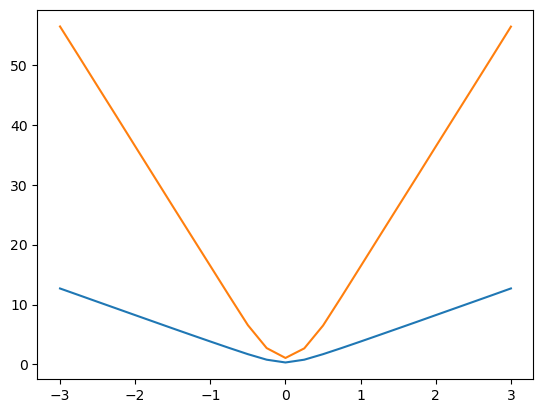

In [48]:
plt.plot(scores_narrow.observation, scores_narrow.ES)
plt.plot(scores_narrow.observation, scores_narrow.WIS)

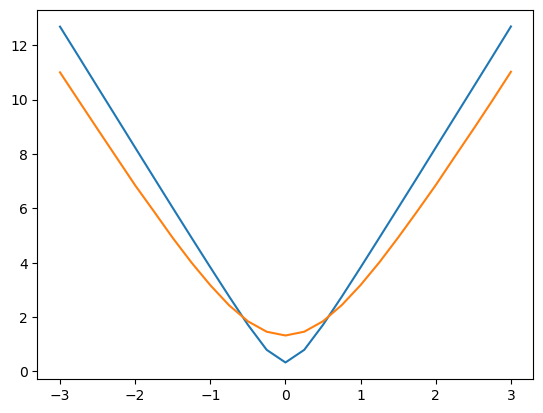

In [49]:
plt.plot(scores_narrow.observation, scores_narrow.ES)
plt.plot(scores.observation, scores.ES)

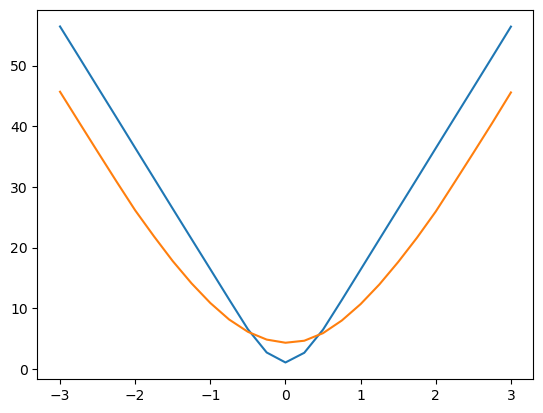

In [51]:
plt.plot(scores_narrow.observation, scores_narrow.WIS)
plt.plot(scores.observation, scores.WIS)

# show proper / strictly proper difference

In [119]:
# Generate true distributions and outcomes
np.random.seed(42)
n = 500
dim = 10  # Dimension of the multivariate distribution
true_means = np.random.rand(n, dim)
outcomes = true_means + np.random.randn(n, dim) * 0.1  # Add some noise

# Generate predicted distributions
predicted_means = np.linspace(0, 1, 100)
predicted_samples = [np.random.randn(n, dim) * 0.1 + mean for mean in predicted_means]

# Calculate Energy Scores
energy_scores = np.zeros(len(predicted_means))
for i, samples in enumerate(predicted_samples):
    scores = [energyscore(samples, outcome) for outcome in outcomes]
    energy_scores[i] = np.mean(scores)
    
WIS_scores = np.zeros(len(predicted_means))
for i, samples in enumerate(predicted_samples):
    scores = [WIS(samples, outcome) for outcome in outcomes]
    WIS_scores[i] = np.mean(scores)


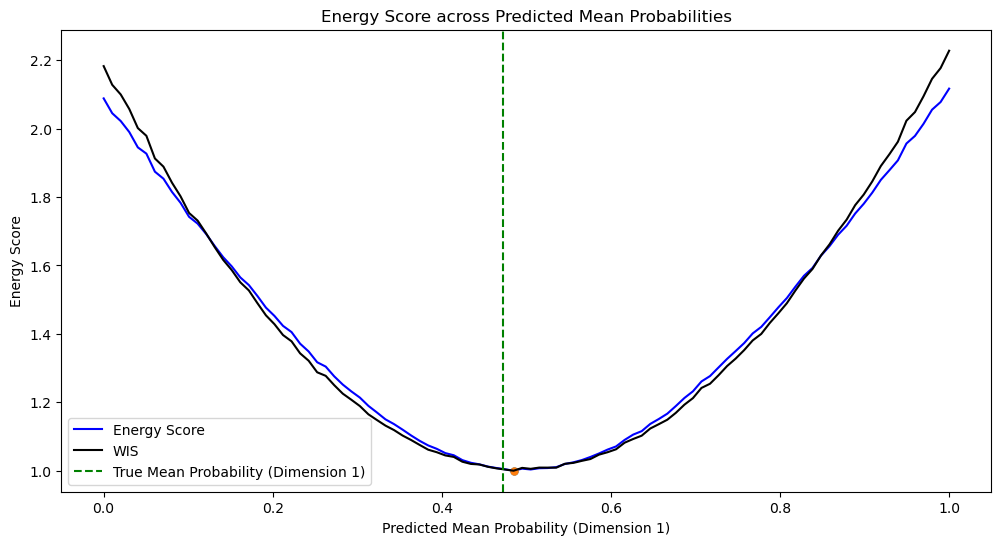

In [121]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(predicted_means, np.array(energy_scores)/min(energy_scores), label='Energy Score', color='blue')
a = list(energy_scores)
ind = a.index(min(a))
plt.plot(predicted_means[ind], a[ind]/min(energy_scores), '.', markersize=10)

a = list(WIS_scores)
ind = a.index(min(a))
plt.plot(predicted_means[ind], a[ind]/min(WIS_scores), '.', markersize=10)
plt.plot(predicted_means, np.array(WIS_scores)/min(WIS_scores), label='WIS', color='k')

plt.axvline(x=np.mean(true_means[:, 0]), color='green', linestyle='--', label='True Mean Probability (Dimension 1)')
plt.xlabel('Predicted Mean Probability (Dimension 1)')
plt.ylabel('Energy Score')
plt.title('Energy Score across Predicted Mean Probabilities')
plt.legend()
plt.show()

# try with model and generative process

In [226]:
N = 100
M = 20

numit = 10


ES1_scores = []
ES2_scores = []
WIS1_scores = []
WIS2_scores = []

truth = []
for i in np.linspace(-2,2,100):
    
    ES1 = []
    ES2 = []
    WIS1 = []
    WIS2 = []
    for _ in range(numit):
        y = np.ones(M)*i
        
        X1 = np.array([generative_process(M) for _ in range(N)])
        X2 = np.array([model_process(M) for _ in range(N)])

        
        ES1.append(energyscore(X1,y))
        ES2.append(energyscore(X2,y))
        WIS1.append(WIS(X1,y))
        WIS2.append(WIS(X2,y))
    ES1_mean = np.mean(ES1)
    ES2_mean = np.mean(ES2)
    WIS1_mean = np.mean(WIS1)
    WIS2_mean = np.mean(WIS2)
    
    ES1_scores.append(ES1_mean)
    ES2_scores.append(ES2_mean)
    
    WIS1_scores.append(WIS1_mean)
    WIS2_scores.append(WIS2_mean)
    
    truth.append(i)

In [228]:
y

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2.])

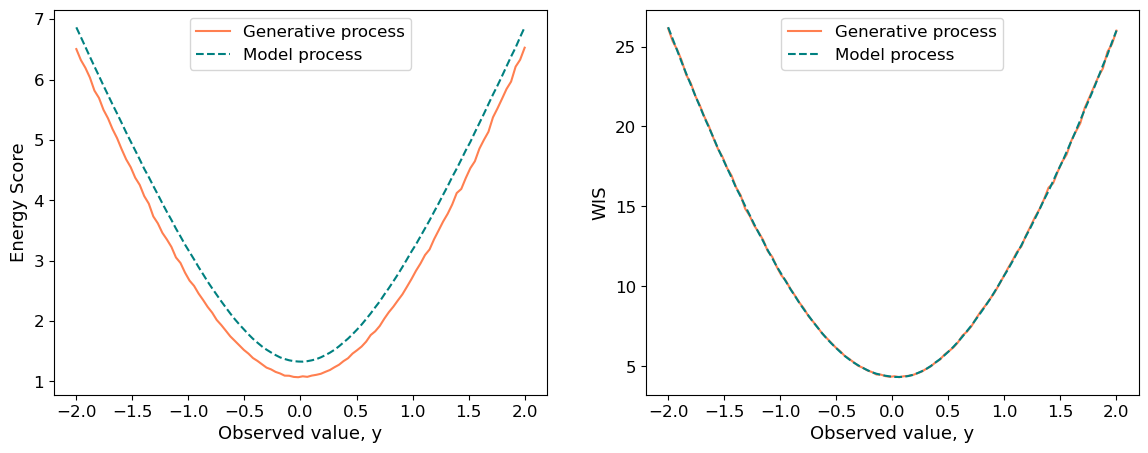

In [224]:
plt.subplots(1,2,figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(truth, np.array(ES1_scores), color='coral', label='Generative process')
plt.plot(truth, np.array(ES2_scores),'--', color='teal', label='Model process')

plt.xlabel('Observed value, y', fontsize=13)
plt.ylabel('Energy Score', fontsize=13)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(fontsize=12)

plt.subplot(1,2,2)

plt.plot(truth, np.array(WIS1_scores), color='coral', label = 'Generative process')
plt.plot(truth, np.array(WIS2_scores),'--', color='teal', label = 'Model process')

plt.xlabel('Observed value, y', fontsize=13)
plt.ylabel('WIS', fontsize=13)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(fontsize=12)

plt.savefig('../figs/proper_test.pdf')

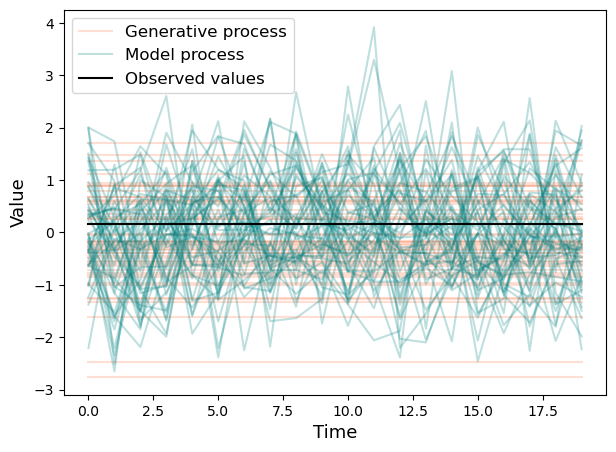

In [236]:
fig, axes = plt.subplots(figsize=(7, 5))
g1 = generative_trajectories(n=50)
g2 = model_trajectories(n=50)
g2['trajectory_id'] = g2['trajectory_id'] + 50
g = pd.concat([g1, g2])

plt.subplot(1,1,1)
for i in g.trajectory_id.unique():
    gf = g[g.trajectory_id == i]
    
    if i <50:
        color = 'coral'
        
    else:
        color =  'teal'
        
    #plt.plot(range(10), gf['value'], color = color, alpha = .25)
    
    if i ==1:
        plt.plot(range(20), gf['value'], color = color, alpha = .25, label ='Generative process')
    elif i==50:
        plt.plot(range(20), gf['value'], color = color, alpha = .25, label='Model process')
    else:
        plt.plot(range(20), gf['value'], color = color, alpha = .25)

plt.plot(range(20), generative_process(), color = 'k', alpha = 1, label='Observed values')
    

    
plt.xlabel('Time', fontsize=13)
plt.ylabel('Value', fontsize=13)

plt.legend(fontsize=12)

#plt.savefig('../figs/trajectories_test_flat.pdf')
plt.show()

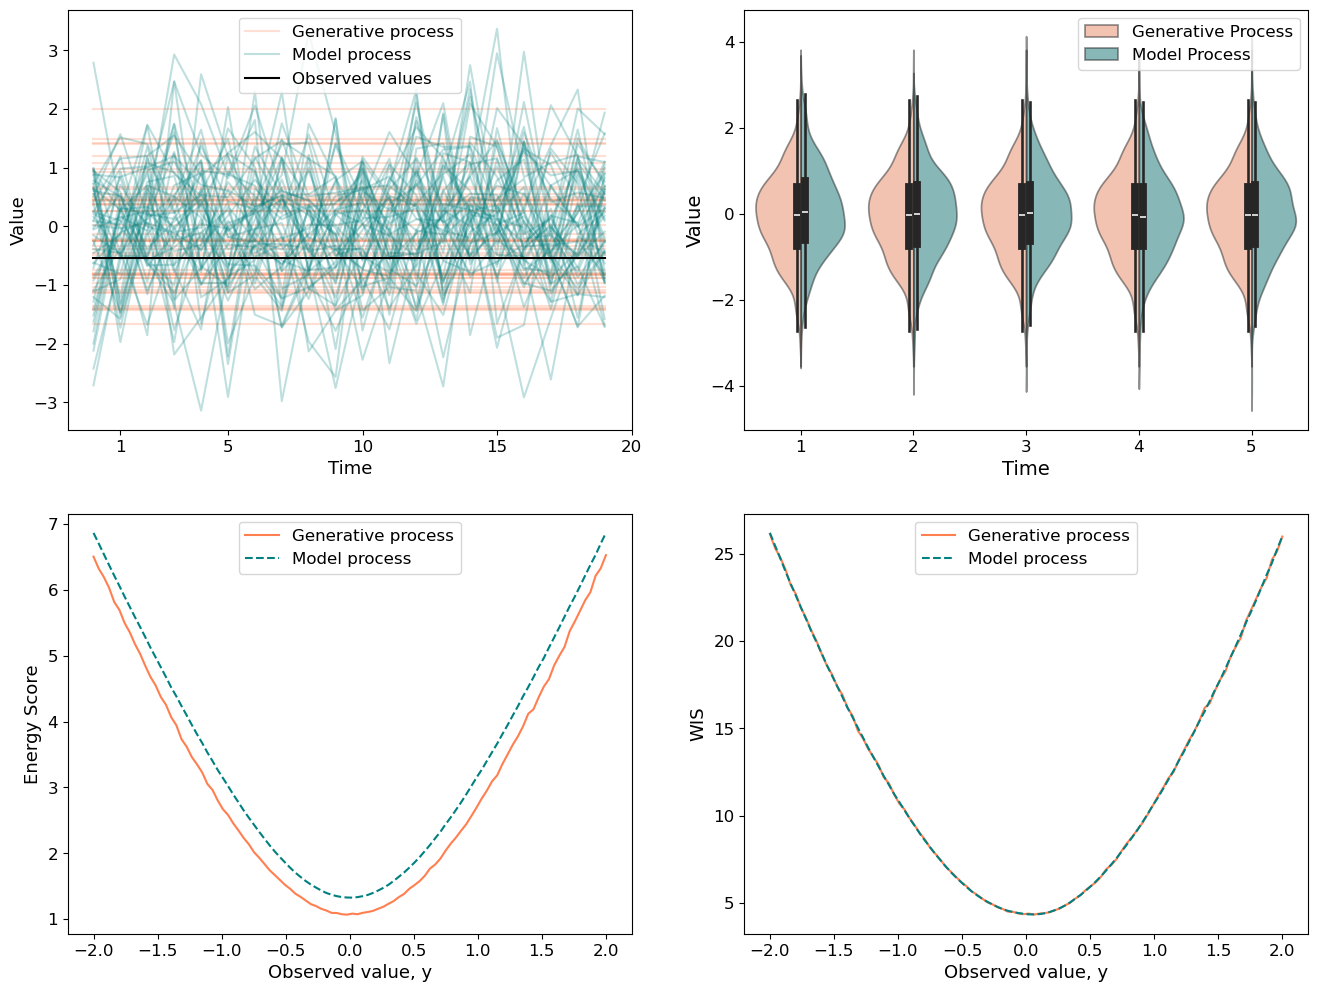

In [250]:
plt.subplots(2,2,figsize=(16,12))

plt.subplot(2,2,1)

g1 = generative_trajectories(n=50)
g2 = model_trajectories(n=50)
g2['trajectory_id'] = g2['trajectory_id'] + 50
g = pd.concat([g1, g2])

for i in g.trajectory_id.unique():
    gf = g[g.trajectory_id == i]
    
    if i <50:
        color = 'coral'
        
    else:
        color =  'teal'
        
    #plt.plot(range(10), gf['value'], color = color, alpha = .25)
    
    if i ==1:
        plt.plot(range(20), gf['value'], color = color, alpha = .25, label ='Generative process')
    elif i==50:
        plt.plot(range(20), gf['value'], color = color, alpha = .25, label='Model process')
    else:
        plt.plot(range(20), gf['value'], color = color, alpha = .25)

plt.plot(range(20), generative_process(), color = 'k', alpha = 1, label='Observed values')
    
plt.xlabel('Time', fontsize=13)
plt.ylabel('Value', fontsize=13)

plt.legend(fontsize=12)
plt.xticks([1,5,10,15,20],fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(2,2,2)

N = 1000
M = 20

X1 = np.array([generative_process(5) for _ in range(N)])
X2 = np.array([model_process(5) for _ in range(N)])

dftot = pd.DataFrame()
for model in ['Generative', 'Model']:
    if model == 'Generative':
        dat = X1
    else:
        dat = X2
    for i in range(len(X1)):
        df = pd.DataFrame(dat[i], columns = ['value'])
        df['time'] = [1,2,3,4,5]
        
        df['Model'] = model + ' Process'
        dftot=pd.concat([dftot, df])

palette = ['coral', 'teal']
#sns.color_palette(palette, 2)
sns.violinplot(x="time", y="value", hue="Model",
            data=dftot, split=True, palette=sns.color_palette(palette, 2), alpha=.5)

plt.xlabel('Time', fontsize=14)
plt.ylabel('Value',fontsize=14)
axes.set_xticklabels([1,2,3,4,5,6,7,8,9,10], fontsize=12)
#axes.set_yticklabels(fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(title='', fontsize=12)



plt.subplot(2,2,3)
plt.plot(truth, np.array(ES1_scores), color='coral', label='Generative process')
plt.plot(truth, np.array(ES2_scores),'--', color='teal', label='Model process')

plt.xlabel('Observed value, y', fontsize=13)
plt.ylabel('Energy Score', fontsize=13)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(fontsize=12)

plt.subplot(2,2,4)

plt.plot(truth, np.array(WIS1_scores), color='coral', label = 'Generative process')
plt.plot(truth, np.array(WIS2_scores),'--', color='teal', label = 'Model process')

plt.xlabel('Observed value, y', fontsize=13)
plt.ylabel('WIS', fontsize=13)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(fontsize=12)

plt.savefig('../figs/proper_test_facet.pdf')

# proper vs strictly proper for SIR curve

In [7]:
# SIR Model

def SIR_model(nsim, beta, mu, pop, nseed):
    Sall = {}
    Iall = {}
    Rall = {}
    for sim in range(nsim):
        numsus = []
        numinf = []
        numrec = []
    
        numsus.append(pop)

        numsus[0] = pop-nseed
        numinf.append(nseed)
        numrec.append(0)
    
        t=0
        while numinf[t]> 0 :
            t+=1
        
            S = numsus[t-1]
            I = numinf[t-1]
            R = numrec[t-1]
            Nnew = S + I + R
            
            # simulate infection in the subpopulation    
            foi = 1 - ((1 - beta/Nnew)**(I) )
            
            ainf = np.random.binomial(S, min(1,foi)) # transmission
            arec = np.random.binomial(I, min(1,mu))
            
            S = S - ainf 
            I = I + ainf - arec
            R = R + arec
        
            numsus.append(S)
            numinf.append(I)
            numrec.append(R)
       
        Sall[sim] = numsus
        Iall[sim] = numinf
        Rall[sim] = numrec
        
    return Sall, Iall, Rall



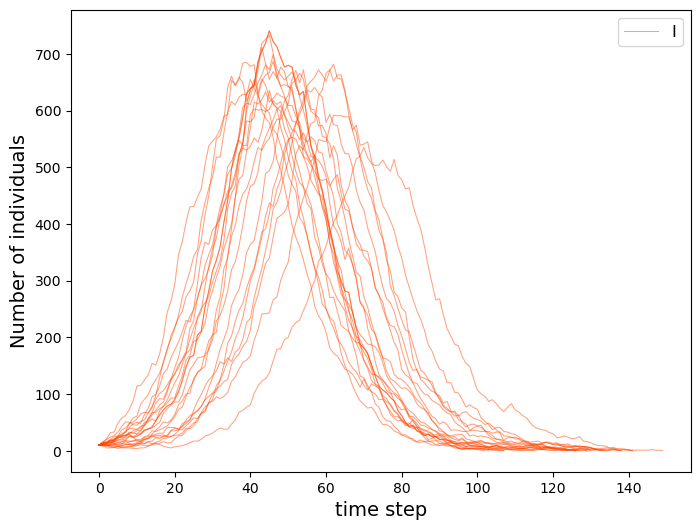

In [19]:
plt.figure(figsize=(8,6))
sim =20
Sall,Iall, Rall = SIR_model(nsim=sim, beta=.375,mu=.25, pop=10000, nseed=10)
for n in range(sim):
    #plt.plot(Sall[n], 'k',linewidth=.75,  alpha=.5)
    plt.plot(Iall[n], 'orangered',linewidth=.75,  alpha=.5)
    #plt.plot(Rall[n], 'forestgreen',linewidth=.75,  alpha=.5)
    
#plt.plot(Sall[n], 'k',linewidth=.75, label='S', alpha=.5)
plt.plot(Iall[n], 'orangered',linewidth=.75, label='I', alpha=.5)
#plt.plot(Rall[n], 'forestgreen',linewidth=.75, label='R', alpha=.5)

plt.legend(fontsize=12)
plt.xlabel('time step', fontsize=14)
plt.ylabel('Number of individuals', fontsize=14)


plt.show()

In [443]:
.25*3

0.75

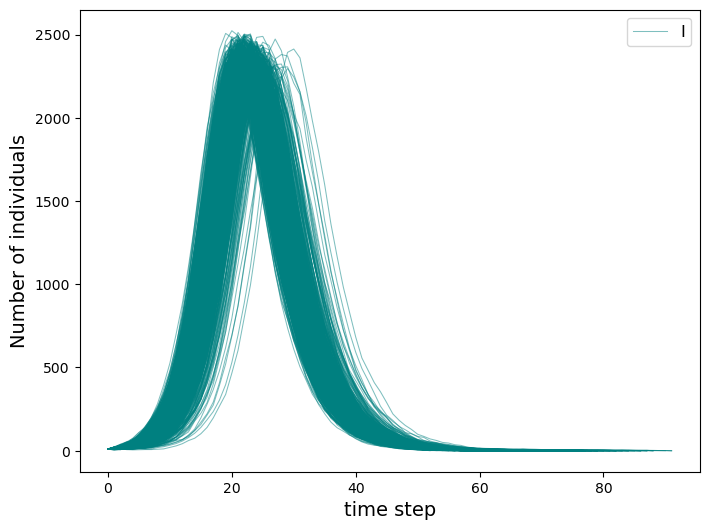

In [487]:
plt.figure(figsize=(8,6))
sim =1000
Sall,Iall, Rall = SIR_model(nsim=sim, beta=.625,mu=.25, pop=10000, nseed=10)
for n in range(sim):
    plt.plot(Iall[n], 'teal',linewidth=.75,  alpha=.5)
    
plt.plot(Iall[n], 'teal',linewidth=.75, label='I', alpha=.5)

plt.legend(fontsize=12)
plt.xlabel('time step', fontsize=14)
plt.ylabel('Number of individuals', fontsize=14)


plt.show()

In [488]:
n=0
Ifilt = {}
for i in Iall.keys():
    if len(Iall[i])>=60:
        Ifilt[n] = Iall[i][0:60]
        n+=1

In [446]:
n

1000

In [489]:
Idf = pd.DataFrame()

time = list(range(1, 61))

for it in range(1, 101):
    traj = Ifilt[it]
    
    for t in time:
        val = traj[t-1]
        
        newrow = pd.DataFrame({'trajectory_id':it, 'time':t, 'I':val}, index=[0])
        
        Idf = pd.concat([Idf, newrow])
    

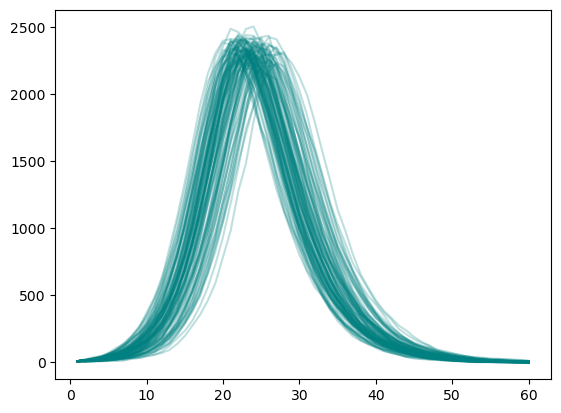

In [490]:
# trajectories kept
for i in Idf.trajectory_id.unique():
    d = Idf[Idf.trajectory_id==i]
    plt.plot(d.time, d.I, color='teal', alpha=.25)

In [64]:
Idf

,trajectory_id,time,I
0,1,1,10
0,1,2,11
0,1,3,9
0,1,4,8
0,1,5,8
...,...,...,...
0,100,116,4
0,100,117,4
0,100,118,3
0,100,119,3


In [359]:
numsamp = 100
I_uncorr = pd.DataFrame()
for samp in range(numsamp):
    for t in Idf.time.unique():
        a = list(Idf[Idf.time==t]['I']) 
        val = random.choice(a)
    
        newrow = pd.DataFrame({'trajectory_id':samp, 'time':t, 'I':val}, index=[0])
        I_uncorr = pd.concat([I_uncorr, newrow])

In [491]:
#without replacement
#numsamp = 100
I_uncorr = pd.DataFrame()
for t in Idf.time.unique():
    a = list(Idf[Idf.time==t]['I']) 
    val = np.random.choice(a,100, replace=False)

    newrow = pd.DataFrame({'trajectory_id':list(range(1,101)), 'time':np.ones(100)*t, 'I':val})
    I_uncorr = pd.concat([I_uncorr, newrow])

In [297]:
I_uncorr

,trajectory_id,time,I
0,1,1.0,10
1,2,1.0,10
2,3,1.0,10
3,4,1.0,10
4,5,1.0,10
...,...,...,...
95,96,250.0,9
96,97,250.0,15
97,98,250.0,1
98,99,250.0,5


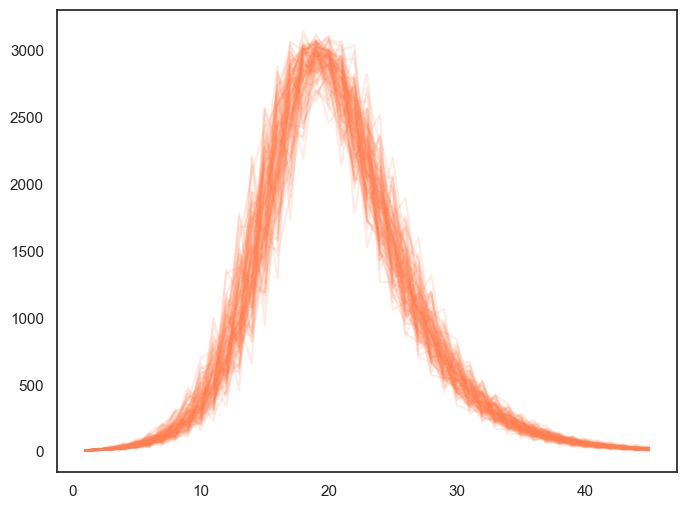

In [450]:
# uncorrelated trajectories
plt.figure(figsize=(8,6))
for i in I_uncorr.trajectory_id.unique():
    if i<500:
        d = I_uncorr[I_uncorr.trajectory_id==i]
        plt.plot(d.time, d.I, color='coral', alpha=.15)

Text(0.5, 0, 'Time')

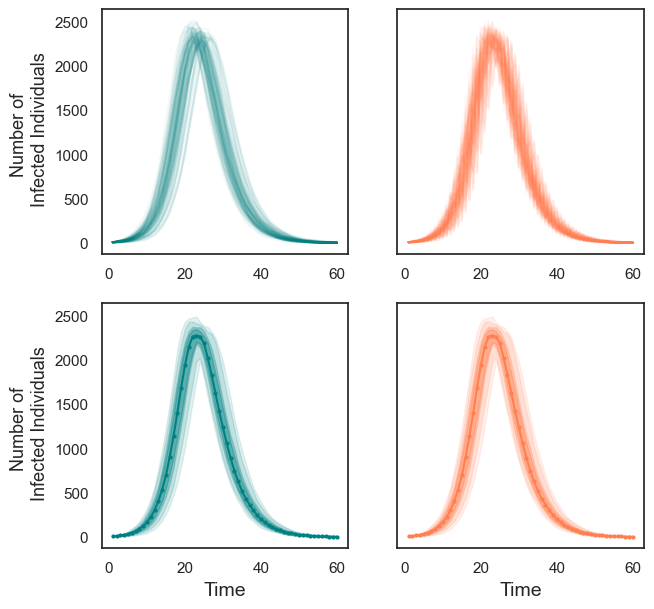

In [362]:
# plot all trajectories
fig = plt.subplots(2,2, figsize=(7,7), sharey=True)

plt.subplot(2,2,1)
for i in Idf.trajectory_id.unique():
    if i<501:
        d = Idf[Idf.trajectory_id==i]
        plt.plot(d.time, d.I, color='teal', alpha=.05)
#plt.xlabel('Time', fontsize=14)
plt.ylabel('Number of \n Infected Individuals', fontsize=13)
        

plt.subplot(2,2,2)
for i in I_uncorr.trajectory_id.unique():
    if i<501:
        d = I_uncorr[I_uncorr.trajectory_id==i]
        plt.plot(d.time, d.I, color='coral', alpha=.05)
#plt.xlabel('Time', fontsize=14)        
        
        
plt.subplot(2,2,3)
map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1
quants = [(0.01,0.99),(0.05,0.95),(.15, .85),(0.25,0.75)]

for q in quants:
    interval_range = q[1] - q[0]
    alpha = map_alpha(interval_range)
    
    qupp = list(Idf.groupby('time')['I'].quantile(q[0]))
    qlow = list(Idf.groupby('time')['I'].quantile(q[1]))
    
    plt.fill_between(Idf.time.unique(),qupp,qlow, color='teal', alpha=alpha)
    
qmed = list(Idf.groupby('time')['I'].quantile(.5))

plt.plot(Idf.time.unique(),qmed,'-o', color='teal', alpha=1,markersize=2,
                               label=fr"Quantile projections")

plt.xlabel('Time', fontsize=14)
plt.ylabel('Number of \n Infected Individuals', fontsize=13)
 

plt.subplot(2,2,4)
map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1
quants = [(0.01,0.99),(0.05,0.95),(.15, .85),(0.25,0.75)]

for q in quants:
    interval_range = q[1] - q[0]
    alpha = map_alpha(interval_range)
    
    qupp = list(I_uncorr.groupby('time')['I'].quantile(q[0]))
    qlow = list(I_uncorr.groupby('time')['I'].quantile(q[1]))
    
    plt.fill_between(I_uncorr.time.unique(),qupp,qlow, color='coral', alpha=alpha)
    
qmed = list(I_uncorr.groupby('time')['I'].quantile(.5))

plt.plot(I_uncorr.time.unique(),qmed,'-o', color='coral', alpha=1,markersize=2,
                               label=fr"Quantile projections")

plt.xlabel('Time', fontsize=14)
#plt.ylabel('Number of Infected Individuals', fontsize=13)
 

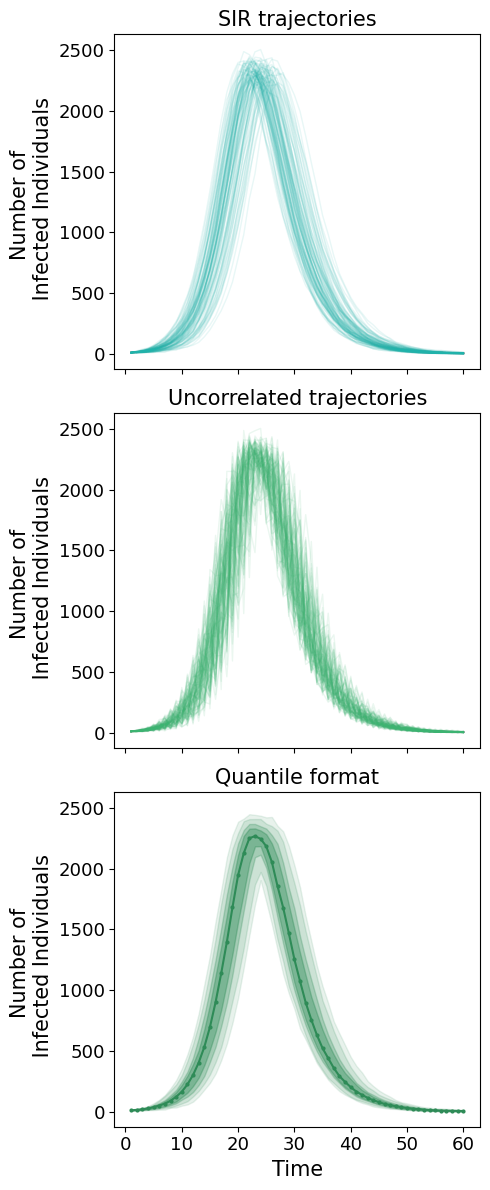

In [497]:
# plot all trajectories
mpl.rc_file_defaults()
fig = plt.subplots(3,1, figsize=(5,12), sharey=True, sharex=True)

plt.subplot(3,1,1)
for i in Idf.trajectory_id.unique():
    if i<501:
        d = Idf[Idf.trajectory_id==i]
        plt.plot(d.time, d.I, color='lightseagreen', alpha=.1, linewidth=1)
#plt.xlabel('Time', fontsize=15)
plt.ylabel('Number of \n Infected Individuals', fontsize=15)
plt.xticks(fontsize=13)  
plt.yticks(fontsize=13)
plt.title('SIR trajectories', fontsize=15)

plt.subplot(3,1,2)
for i in I_uncorr.trajectory_id.unique():
    if i<501:
        d = I_uncorr[I_uncorr.trajectory_id==i]
        plt.plot(d.time, d.I, color='mediumseagreen', alpha=.1, linewidth=1)
#plt.xlabel('Time', fontsize=15)        
plt.xticks(fontsize=13) 
plt.title('Uncorrelated trajectories', fontsize=15)
plt.ylabel('Number of \n Infected Individuals', fontsize=15)
plt.yticks(fontsize=13)
        
plt.subplot(3,1,3)
map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1
quants = [(0.01,0.99),(0.05,0.95),(.15, .85),(0.25,0.75)]

for q in quants:
    interval_range = q[1] - q[0]
    alpha = map_alpha(interval_range)
    
    qupp = list(Idf.groupby('time')['I'].quantile(q[0]))
    qlow = list(Idf.groupby('time')['I'].quantile(q[1]))
    
    plt.fill_between(Idf.time.unique(),qupp,qlow, color='seagreen', alpha=alpha)
    
qmed = list(Idf.groupby('time')['I'].quantile(.5))

plt.plot(Idf.time.unique(),qmed,'-o', color='seagreen', alpha=1,markersize=2,
                               label=fr"Quantile projections")

plt.xlabel('Time', fontsize=15)
plt.ylabel('Number of \n Infected Individuals', fontsize=15)
#plt.ylabel('Number of \n Infected Individuals', fontsize=13)
plt.yticks(fontsize=13)
 
plt.xticks(fontsize=13)
plt.title('Quantile format', fontsize=15)

plt.tight_layout()
plt.savefig('../figs/SIR_uncorr_traj_R02_5_vert.pdf')


In [452]:
Idf['Model'] = 'SIR'
I_uncorr['Model'] = 'uncorrelated'

dftot = pd.concat([Idf, I_uncorr])



In [124]:
dftot

,trajectory_id,time,I,Model
0,1,1,10,SIR
0,1,2,10,SIR
0,1,3,14,SIR
0,1,4,20,SIR
0,1,5,19,SIR
...,...,...,...,...
0,99,116,14,uncorrelated
0,99,117,13,uncorrelated
0,99,118,3,uncorrelated
0,99,119,68,uncorrelated


Text(0, 0.5, 'Value')

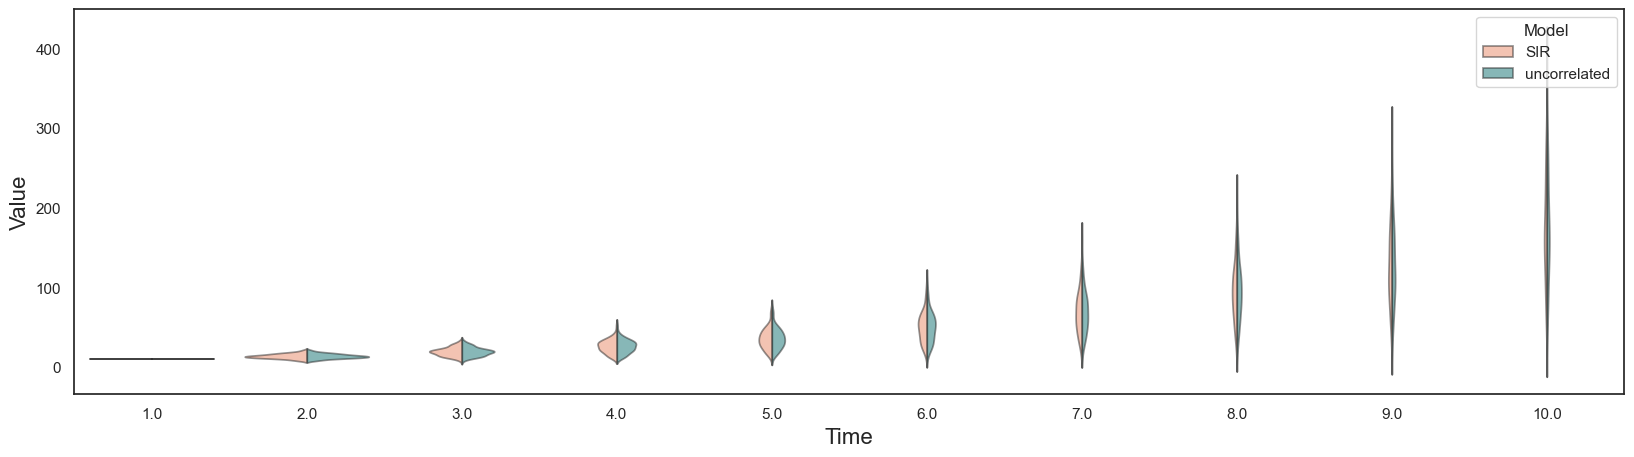

In [392]:


dffilt = dftot[dftot.time<11]
palette = ['coral', 'teal']
#sns.color_palette(palette, 2)
sns.set_theme(rc={'figure.figsize':(20,5)}, style='white')
sns.violinplot(x="time", y="I", hue="Model",
            data=dffilt, split=True, inner = None,palette=sns.color_palette(palette, 2), alpha=.5)

plt.xlabel('Time', fontsize=16)
plt.ylabel('Value',fontsize=16)


In [453]:
#calculate scores

def get_SIR_trajectories(sim=1000):

    #sim =200
    Sall,Iall, Rall = SIR_model(nsim=sim, beta=.625,mu=.25, pop=10000, nseed=10)

    n=0
    Ifilt = {}
    for i in Iall.keys():
        if len(Iall[i])>=60:
            Ifilt[n] = Iall[i][0:60]
            n+=1

    Idf = pd.DataFrame()
    time = list(range(1, 61))

    for it in range(1, 101):
        traj = Ifilt[it]

        for t in time:
            val = traj[t-1]

            newrow = pd.DataFrame({'trajectory_id':it, 'time':t, 'I':val}, index=[0])
            Idf = pd.concat([Idf, newrow])

    I_uncorr = pd.DataFrame()
    for t in Idf.time.unique():
        a = list(Idf[Idf.time==t]['I']) 
        val = np.random.choice(a,100, replace=False)

        newrow = pd.DataFrame({'trajectory_id':list(range(1,101)), 'time':np.ones(100)*t, 'I':val})
        I_uncorr = pd.concat([I_uncorr, newrow]) 

    Idf['Model'] = 'SIR'
    I_uncorr['Model'] = 'uncorrelated'

    dftot = pd.concat([Idf, I_uncorr])

    return dftot

In [454]:
numit = 200

ES_SIR = []
ES_uncorr = []
WIS_SIR = []
WIS_uncorr = []

truth = []
for i in range(numit):
    
  #  ES1 = []
  #  ES2 = []
 #   WIS1 = []
 #   WIS2 = []
    y=np.array([])
    while y.shape[0]<60:
        Sall,Iall, Rall = SIR_model(nsim=1, beta=.625,mu=.25, pop=10000, nseed=10)
        y = np.array(Iall[0][0:60]).astype(float) 
        
    dftot = get_SIR_trajectories(sim=800)

    SIRdf = dftot[dftot.Model=='SIR']
    SIR_X = np.array([np.array(SIRdf[SIRdf['trajectory_id'] == i].I) for i in SIRdf['trajectory_id'].unique()]).astype(float) 
    
    uncorrdf = dftot[dftot.Model=='uncorrelated']
    uncorr_X = np.array([np.array(uncorrdf[uncorrdf['trajectory_id'] == i].I) for i in uncorrdf['trajectory_id'].unique()]).astype(float) 


    ES_SIR.append(energyscore(SIR_X ,y))
    ES_uncorr.append(energyscore(uncorr_X,y))
    WIS_SIR.append(WIS(SIR_X,y))
    WIS_uncorr.append(WIS(uncorr_X,y))
    
    
 #   ES1_mean = np.mean(ES1)
 #   ES2_mean = np.mean(ES2)
 #   WIS1_mean = np.mean(WIS1)
 #   WIS2_mean = np.mean(WIS2)
    
 #   ES1_scores.append(ES1_mean)
 #   ES2_scores.append(ES2_mean)
    
  #  WIS1_scores.append(WIS1_mean)
  #  WIS2_scores.append(WIS2_mean)
    
    #truth.append(i)

In [468]:
ESdf_3 = pd.DataFrame({'Model':'SIR', 'value':ES_SIR})
ESdf_3 = pd.concat([ESdf_3,pd.DataFrame({'Model':'uncorrelated', 'value':ES_uncorr})])

WISdf_3 = pd.DataFrame({'Model':'SIR', 'value':WIS_SIR})
WISdf_3 = pd.concat([WISdf_3,pd.DataFrame({'Model':'uncorrelated', 'value':WIS_uncorr})])

<Axes: xlabel='value', ylabel='Model'>

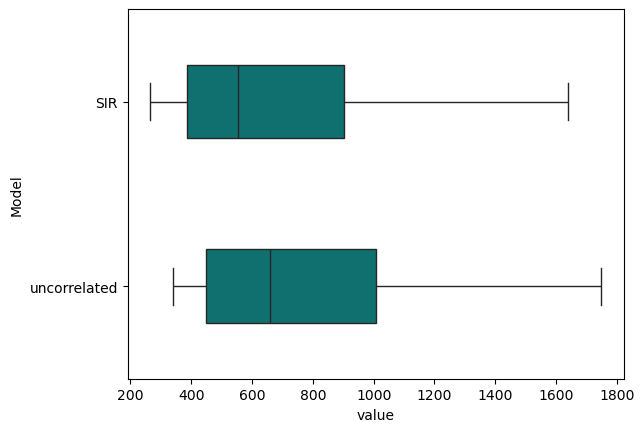

In [469]:
sns.boxplot(x='value', y='Model', data=ESdf_3,color='teal', width=0.4, showfliers=False)

<Axes: xlabel='value', ylabel='Model'>

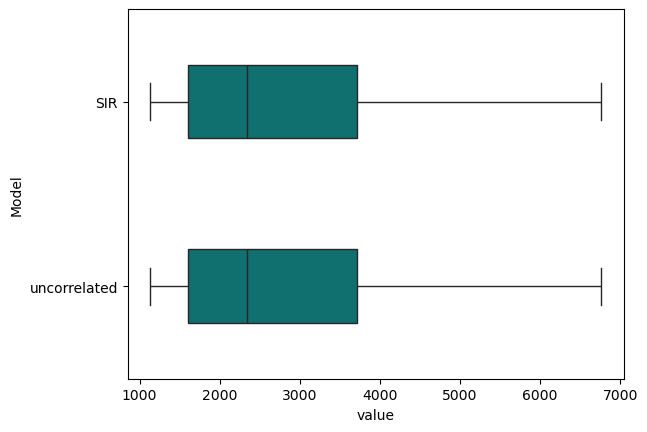

In [470]:
sns.boxplot(x='value', y='Model', data=WISdf_3,color='teal', width=0.4, showfliers=False)

<Axes: xlabel='value', ylabel='Density'>

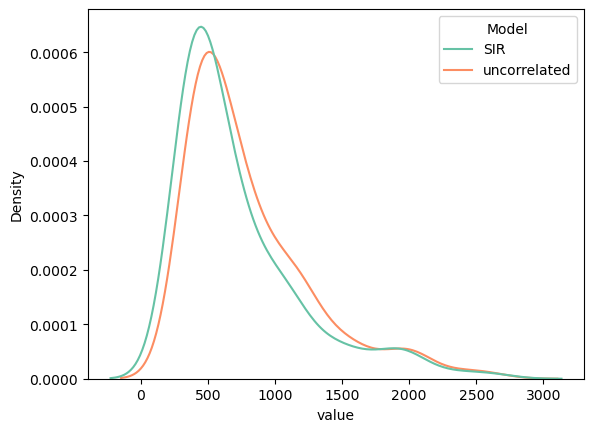

In [471]:
sns.kdeplot(x='value', hue='Model', data=ESdf_3,palette='Set2')

<Axes: xlabel='value', ylabel='Density'>

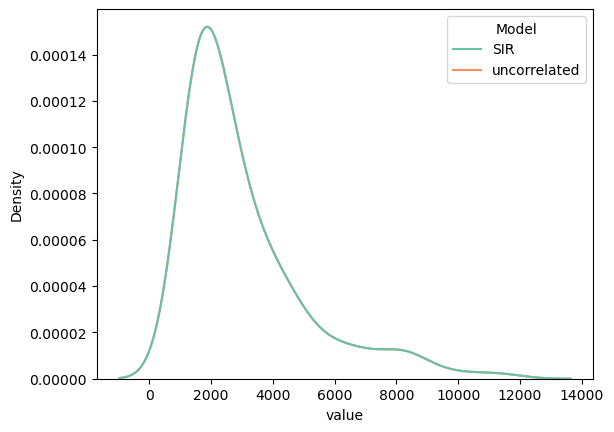

In [472]:
sns.kdeplot(x='value', hue='Model', data=WISdf_3,palette='Set2')

501.2693632264502
589.5960669204595


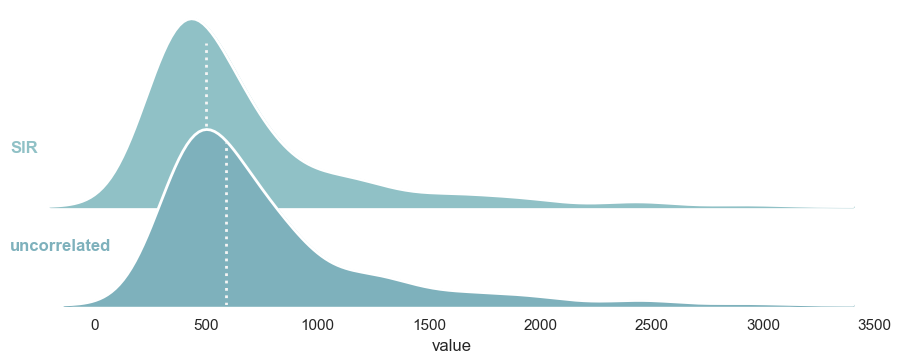

In [347]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})


# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(ESdf, row="Model", hue="Model", aspect=5, height=2, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "value",
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "value", clip_on=False, color="w", lw=2, bw_adjust=1)

# passing color=None to refline() uses the hue mapping
#g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .3, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "value")

# Define a function to plot the median
def plot_median(data, color, label):
    median = np.median(data['value'])
    plt.axvline(median,ymin=0, ymax=.83, color='whitesmoke', linestyle=':', linewidth=2)
    print(median)
    
# Apply the function to plot the median
g.map_dataframe(plot_median)


# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.5)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

#plt.xlim([-45, 32])
#plt.xlabel('Delay in onset of local transmission (days)', fontsize=12)
#plt.ylabel('% infectious-detectable \n stopped '+r'from traveling, $\phi_b$', y=1.1, fontsize=12)


2300.0455315217387
2300.0455315217387


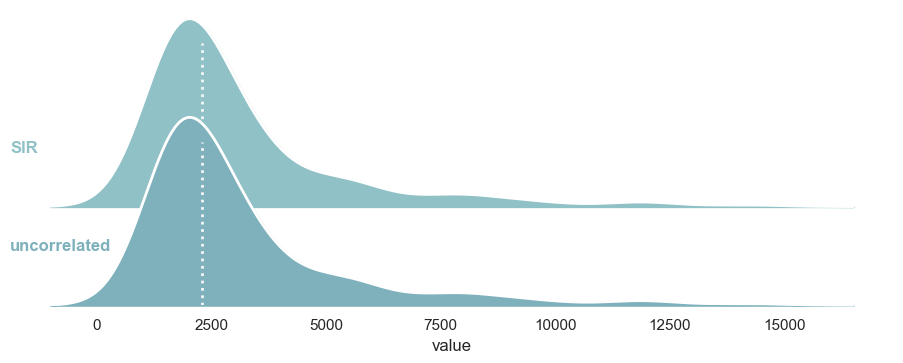

In [348]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})


# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(WISdf, row="Model", hue="Model", aspect=5, height=2, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "value",
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "value", clip_on=False, color="w", lw=2, bw_adjust=1)

# passing color=None to refline() uses the hue mapping
#g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .3, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "value")

# Define a function to plot the median
def plot_median(data, color, label):
    median = np.median(data['value'])
    plt.axvline(median,ymin=0, ymax=.83, color='whitesmoke', linestyle=':', linewidth=2)
    print(median)
    
# Apply the function to plot the median
g.map_dataframe(plot_median)


# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.5)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

#plt.xlim([-45, 32])
#plt.xlabel('Delay in onset of local transmission (days)', fontsize=12)
#plt.ylabel('% infectious-detectable \n stopped '+r'from traveling, $\phi_b$', y=1.1, fontsize=12)


<Axes: xlabel='value', ylabel='Density'>

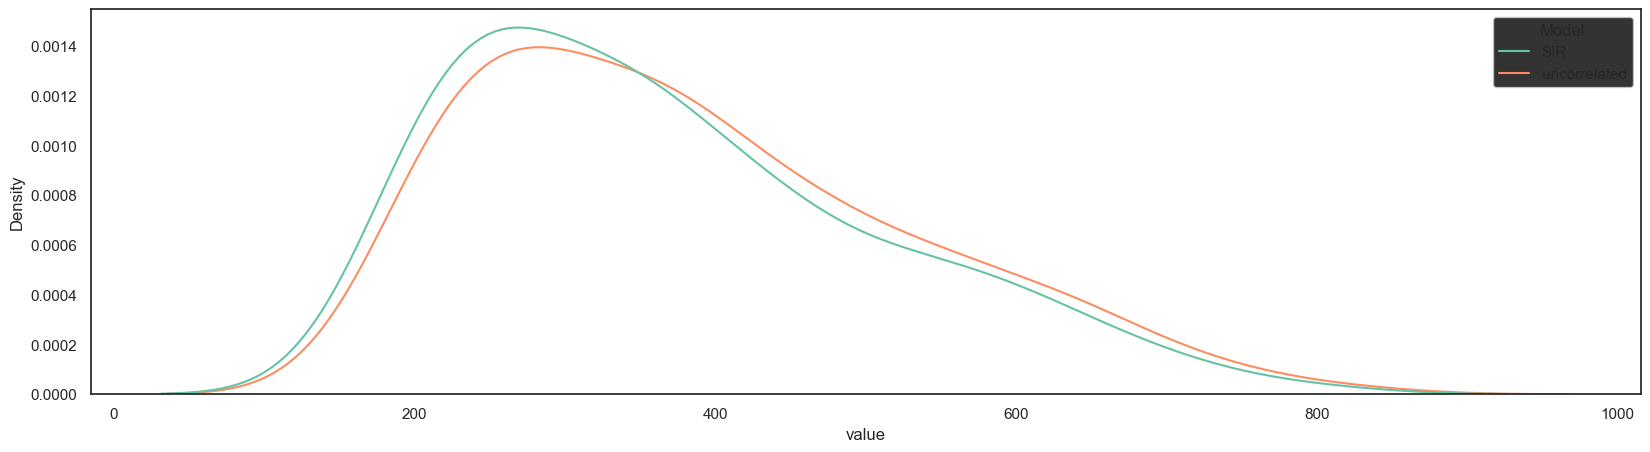

In [325]:
sns.kdeplot(x='value', hue='Model', data=ESdf,palette='Set2')

<Axes: xlabel='value', ylabel='Density'>

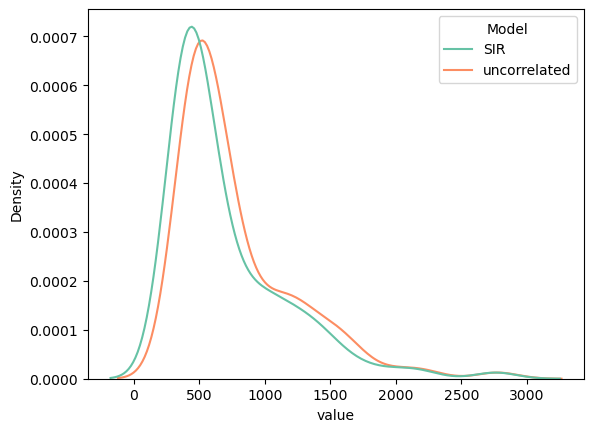

In [479]:
sns.kdeplot(x='value', hue='Model', data=ESdf,palette='Set2')

<Axes: xlabel='value', ylabel='Density'>

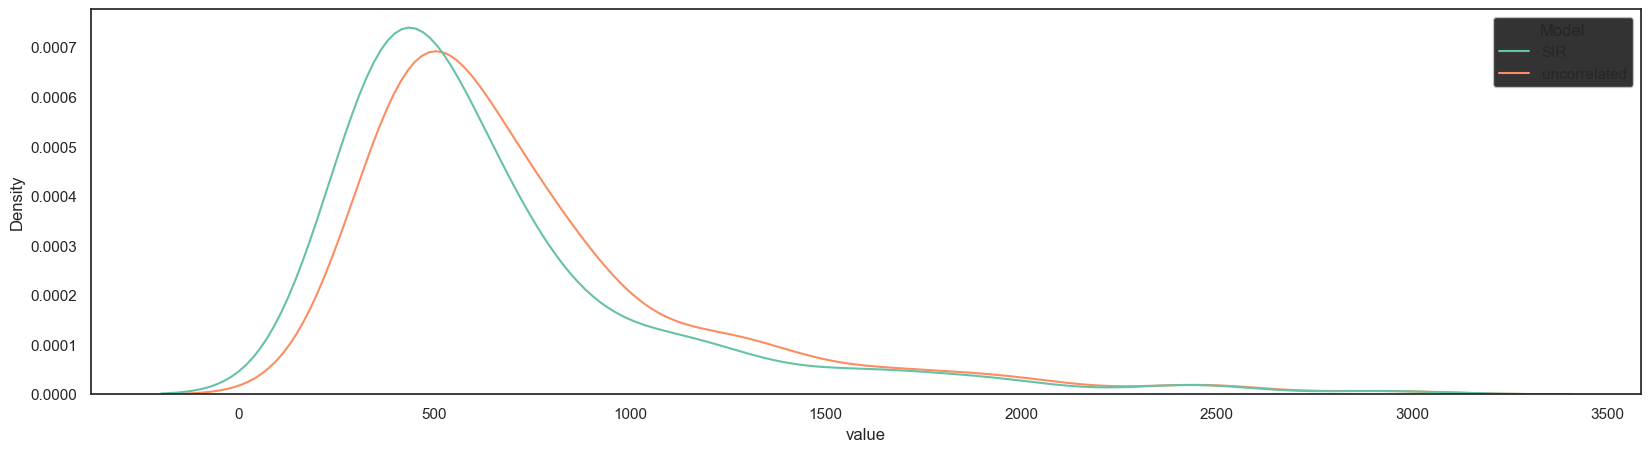

In [349]:
sns.kdeplot(x='value', hue='Model', data=ESdf,palette='Set2')

514.0551016772736
604.6654709204546
2397.064852173913
2397.064852173913


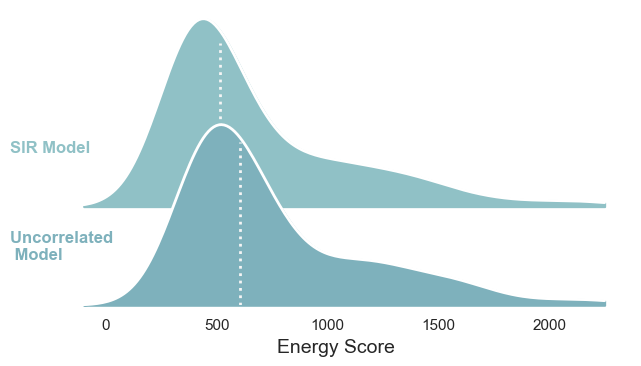

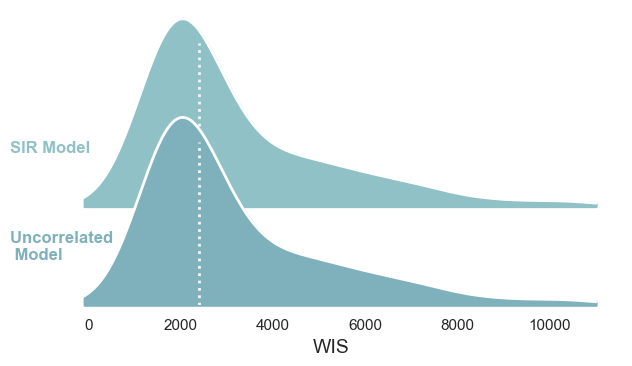

In [432]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
dfs = [ESdf, WISdf]
scores = ['Energy Score', 'WIS']

i=1
#plt.subplots(1,2, figsize=(15,5))
for df in dfs:
    if i==1:
        maxi=2250
    else:
        maxi=11000
        
    df = df.copy()
    df['Model'] = df['Model'].apply(lambda x: 'SIR Model' if x == 'SIR' else 'Uncorrelated \n Model')
    #plt.subplot(1,2,i)
    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(df, row="Model", hue="Model", aspect=3.5, height=2, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "value",
          bw_adjust=1, clip_on=False,
          fill=True, alpha=1, linewidth=1.5, clip = (-100,maxi))
    g.map(sns.kdeplot, "value", clip_on=False, color="w", lw=2, bw_adjust=1, clip = (-500,maxi))

    # passing color=None to refline() uses the hue mapping
    #g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(-.05, .3, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, "value")

    # Define a function to plot the median
    def plot_median(data, color, label):
        median = np.median(data['value'])
        plt.axvline(median,ymin=0, ymax=.83, color='whitesmoke', linestyle=':', linewidth=2)
        print(median)

    # Apply the function to plot the median
    g.map_dataframe(plot_median)


    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-.5)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

    #plt.xlim([-45, 32])
    plt.xlabel(scores[i-1], fontsize=14)
    #plt.ylabel('% infectious-detectable \n stopped '+r'from traveling, $\phi_b$', y=1.1, fontsize=12)
    
    
   

  #  plt.savefig(f'../figs/dist_SIRtest_{scores[i-1]}.pdf')
    
    
    i+=1
    
    

In [404]:
df['Model'] = df['Model'].apply(lambda x: 'SIR Model' if x == 'SIR' else 'Uncorrelated Model')

In [483]:
ESdf.groupby('Model').median()

,value
Model,
SIR,514.055102
uncorrelated,604.665471


In [486]:
WISdf.groupby('Model').median()

,value
Model,
SIR,2397.064852
uncorrelated,2397.064852


In [530]:
ESdf['score'] = 'Energy Score'
WISdf['score'] = 'WIS'

allscore = pd.concat([ESdf, WISdf])

allscore.groupby(by=['Model', 'score']).max().to_csv('../fludat/es_wis_test_maxscore.csv')
scoremax = pd.read_csv('../fludat/es_wis_test_maxscore.csv').rename(columns={'value':'max_value'})

allscore = allscore.merge(scoremax, on=['Model', 'score'])

allscore['normalized_value'] = allscore['value'] / allscore['max_value']
allscore['Model'] = allscore['Model'].apply(lambda x: 'SIR Model' if x == 'SIR' else 'Uncorrelated Model')

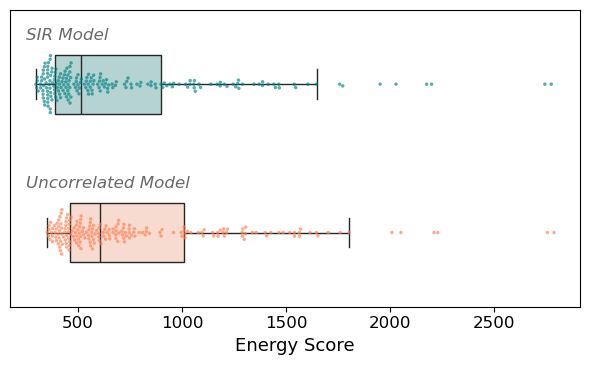

In [570]:
fig,ax = plt.subplots(figsize=(6,3.75))
palette = ['teal', 'coral']


g=sns.boxplot(x='value', y='Model', data=ESdf,hue='Model', width=0.4, showfliers=False, 
            palette=palette)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .3))


sns.swarmplot(x='value', y='Model', data=ESdf,hue='Model', palette=palette,
              alpha = .65,size=2.5, orient="h",)    

g.set(ylabel=None)
g.set(yticklabels=[])
g.set(yticks=[])

a = 0
for mod in ['SIR Model', 'Uncorrelated Model']:
    plt.text(250,a-.3, mod, fontsize=12, style='italic', color='dimgray')
    a+=1

plt.xlabel('Energy Score', fontsize=13)
plt.xticks(fontsize=12)
#plt.legend(title=None)
plt.tight_layout()

plt.savefig('../figs/sir_test_ES_boxplots.pdf')
plt.show()

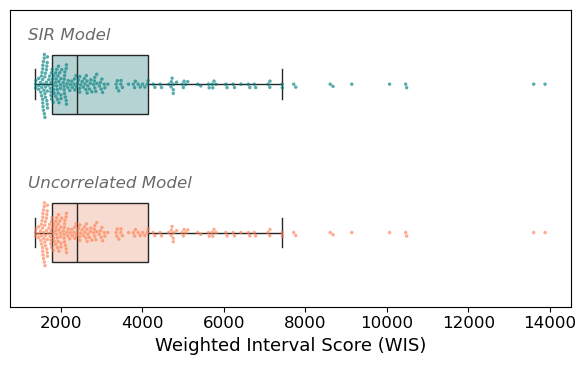

In [571]:
fig,ax = plt.subplots(figsize=(6,3.75))
palette = ['teal', 'coral']


g=sns.boxplot(x='value', y='Model', data=WISdf,hue='Model', width=0.4, showfliers=False, 
            palette=palette)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .3))


sns.swarmplot(x='value', y='Model', data=WISdf,hue='Model', palette=palette,
              alpha = .65,size=2.5, orient="h",)    

g.set(ylabel=None)
g.set(yticklabels=[])
g.set(yticks=[])

a = 0
for mod in ['SIR Model', 'Uncorrelated Model']:
    plt.text(1200,a-.3, mod, fontsize=12, style='italic', color='dimgray')
    a+=1

plt.xlabel('Weighted Interval Score (WIS)', fontsize=13)
plt.xticks(fontsize=12)
#plt.legend(title=None)
plt.tight_layout()
plt.savefig('../figs/sir_test_WIS_boxplots.pdf')
plt.show()

In [580]:
WISdf.groupby('Model').quantile(.75)

,value
Model,
SIR,4128.61539
uncorrelated,4128.61539
